<a href="https://colab.research.google.com/github/navneetkrc/Keras_IMDB/blob/master/IMDB_RNN_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMDB Dataset: Sentiement Analysis

**Using 1D Convnets + GRU layers, and Word Embeddings. 88.78% Validation Accuracy. 85.34% Testing Accuracy.**

In [0]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
from keras.datasets import imdb
from keras import models
from keras import layers
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [0]:
max_features = 10000  # Only include top 10,000 words in the vocabulary
maxlen = 500  # Cut off each review after 500 words
batch_size = 32

##My dataset

In [4]:
![ ! -d data ] && mkdir data/
![ -f data/aclImdb_v1.tar.gz ] && echo "Skip Download"
![ ! -f data/aclImdb_v1.tar.gz ] && wget -N https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz -P data/

--2019-08-31 17:37:46--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘data/aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  21.0MB/s    in 6.8s    

2019-08-31 17:37:54 (11.9 MB/s) - ‘data/aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [5]:
%%time
![ -d data/aclImdb/ ] && echo "Data already extracted"
![ ! -d data/aclImdb/ ] && tar -xzf data/aclImdb_v1.tar.gz -C data/

CPU times: user 71.7 ms, sys: 15.3 ms, total: 87.1 ms
Wall time: 11.7 s


#original process

In [6]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words = max_features)

17465344/17464789 [==============================] - 3s 0us/step


In [7]:
X_train.shape, X_test.shape

((25000,), (25000,))

In [8]:
y_train[1], y_train[2], y_test[4]

(0, 0, 1)

In [0]:
# Padding the data so that each sequence is of exactly 500 words

X_train = pad_sequences(X_train, maxlen = maxlen)
X_test = pad_sequences(X_test, maxlen = maxlen)

In [10]:
X_train.shape, X_test.shape

((25000, 500), (25000, 500))

In [11]:
# Building the Model

model = models.Sequential()
model.add(layers.Embedding(max_features, 32, input_length = maxlen))
model.add(layers.Conv1D(32, 5, activation = 'relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation = 'relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Dropout(0.2))
model.add(layers.CuDNNGRU(32))  # return_sequences = False
model.add(layers.Dense(1, activation = 'sigmoid'))

W0831 17:40:41.062589 139910763235200 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0831 17:40:41.113735 139910763235200 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0831 17:40:41.125632 139910763235200 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0831 17:40:41.177429 139910763235200 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0831 17:40:41.203715 139910763235200 deprecation_wrapp

Since CuDNN doesn't support dropout and recurrent_dropout, we couldn't write the following:

model.add(layers.CuDNNLSTM(32, dropout = 0.1, recurrent_dropout = 0.5))

Hence, our model will be inferior in case of small datasets: https://github.com/keras-team/keras/issues/8935


In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           320000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 496, 32)           5152      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 165, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 161, 32)           5152      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 53, 32)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 53, 32)            0         
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 32)               

In [13]:
# Compiling the Model

model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['acc'])# Compiling the Model

W0831 17:40:43.451728 139910763235200 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0831 17:40:43.488396 139910763235200 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3657: The name tf.log is deprecated. Please use tf.math.log instead.

W0831 17:40:43.496586 139910763235200 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [14]:
# Training

history = model.fit(X_train, y_train, batch_size = batch_size, epochs = 15, validation_split = 0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/15
20000/20000 [==============================] - 17s 853us/step - loss: 0.4361 - acc: 0.7792 - val_loss: 0.3013 - val_acc: 0.8750
Epoch 2/15
20000/20000 [==============================] - 10s 518us/step - loss: 0.2519 - acc: 0.9013 - val_loss: 0.2782 - val_acc: 0.8844
Epoch 3/15
20000/20000 [==============================] - 10s 514us/step - loss: 0.1986 - acc: 0.9259 - val_loss: 0.3458 - val_acc: 0.8574
Epoch 4/15
20000/20000 [==============================] - 10s 511us/step - loss: 0.1597 - acc: 0.9420 - val_loss: 0.3047 - val_acc: 0.8862
Epoch 5/15
20000/20000 [==============================] - 10s 515us/step - loss: 0.1302 - acc: 0.9532 - val_loss: 0.3199 - val_acc: 0.8772
Epoch 6/15
20000/20000 [==============================] - 10s 515us/step - loss: 0.1020 - acc: 0.9643 - val_loss: 0.3884 - val_acc: 0.8728
Epoch 7/15
20000/20000 [==============================] - 10s 517us/step - loss: 0.0743 - acc: 0.9761 - val_loss: 0.4

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']

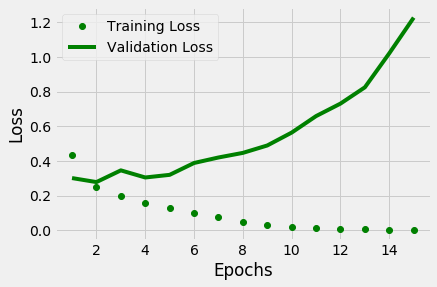

In [16]:
# Plotting Training and Validation Loss

epochs = range(1, 16)

plt.plot(epochs, loss, 'go', label = 'Training Loss')
plt.plot(epochs, val_loss, 'g', label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

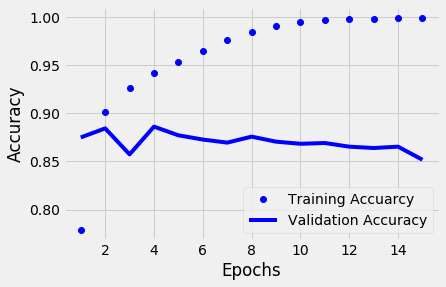

In [17]:
# Plotting Training and Validation Accuracy

plt.plot(epochs, acc, 'bo', label = 'Training Accuarcy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [18]:
# Testing

model.evaluate(X_test, y_test)

25000/25000 [==============================] - 4s 168us/step


[1.301112588903308, 0.8444]